# 統計検定 模擬問題解説 (問9, 10, 11, 12)


本ノートブックでは、クロス集計表の解析（問9）、正則化回帰（問10）、因子分析（問11）、時系列解析（問12）について、
理論解説とPythonによる実装・可視化を行います。


## 問9：χ²検定・連関係数・対応分析


### 1. データの定義とχ²検定の実施


与えられた6×7のクロス集計表（年代 × メディア利用）を定義し、独立性の検定を行います。


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import scipy.stats as stats
import seaborn as sns

# データ定義 (行: 10代~60代, 列: TV~Other)
# Columns: TV, Radio, News, Mag, Book, Net, Other
data = np.array([
    [94, 2, 15, 0, 4, 23, 1],   # 10代
    [106, 3, 41, 0, 2, 64, 3],  # 20代
    [133, 2, 53, 1, 6, 73, 7],  # 30代
    [186, 3, 55, 1, 3, 56, 6],  # 40代
    [157, 6, 67, 0, 1, 24, 2],  # 50代
    [203, 7, 69, 1, 4, 15, 1]   # 60代
])

generations = ['10代', '20代', '30代', '40代', '50代', '60代']
media = ['TV', 'Radio', '新聞', '雑誌', '書籍', 'ネット', 'その他']

df_obs = pd.DataFrame(data, index=generations, columns=media)
print("観測度数表 (O):")
display(df_obs)
display(df_obs.sum(axis=1).rename("行合計"))
display(df_obs.sum(axis=0).rename("列合計"))


観測度数表 (O):


,TV,Radio,新聞,雑誌,書籍,ネット,その他
10代,94,2,15,0,4,23,1
20代,106,3,41,0,2,64,3
30代,133,2,53,1,6,73,7
40代,186,3,55,1,3,56,6
50代,157,6,67,0,1,24,2
60代,203,7,69,1,4,15,1


10代    139
20代    219
30代    275
40代    310
50代    257
60代    300
Name: 行合計, dtype: int64

TV       879
Radio     23
新聞       300
雑誌         3
書籍        20
ネット      255
その他       20
Name: 列合計, dtype: int64

In [2]:
# χ²検定
chi2, p, dof, expected = stats.chi2_contingency(df_obs, correction=False)
df_exp = pd.DataFrame(expected, index=generations, columns=media)

print(f"χ²統計量: {chi2:.4f}")
print(f"自由度: {dof}")
print(f"P値: {p:.4e}")

# Cramér's V
n = data.sum()
k = min(data.shape) - 1
V = np.sqrt(chi2 / (n * k))
print(f"Cramér's V: {V:.4f}")


χ²統計量: 116.5249
自由度: 30
P値: 3.8762e-12
Cramér's V: 0.1246


### 1.1 χ²=116.52 になるまでの途中計算（省略なし）

以下では、観測度数 $O_{G,U}$ と期待度数 $E_{G,U}$ を使って、
各セルの寄与 $(O-E)^2/E$ をすべて計算し、
その総和が $\chi^2=116.5249\dots$ になることを確認します。

- 期待度数は $E_{G,U} = R_G C_U / n$
- 寄与は $x_{G,U} = (O_{G,U}-E_{G,U})^2 / E_{G,U}$
- 合計が $\chi^2 = \sum_{G,U} x_{G,U}$


In [ ]:
# 各セルの途中計算（O, E, O-E, (O-E)^2, (O-E)^2/E）
steps = ["O", "E", "O-E", "(O-E)^2", "(O-E)^2/E"]
dfs = [
    df_obs,
    df_exp,
    df_obs - df_exp,
    (df_obs - df_exp) ** 2,
    (df_obs - df_exp) ** 2 / df_exp,
]
calc_swapped = pd.concat(dfs, keys=steps, axis=1).swaplevel(0, 1, axis=1)
calc = calc_swapped[media]

# 行ごとの寄与合計と全体合計
row_sum = calc.xs("(O-E)^2/E", level=1, axis=1).sum(axis=1)
col_sum = calc.xs("(O-E)^2/E", level=1, axis=1).sum(axis=0)
chi2_total = row_sum.sum()

display(calc)
display(pd.DataFrame({"row_χ2_sum": row_sum}))
display(pd.DataFrame({"col_χ2_sum": col_sum}))
print(f"χ²合計: {chi2_total:.6f}")


### 2. 解説：度数a倍の効果とP値・Vの関係



**〔15〕度数を「全部 a 倍」したとき**
*   **χ²統計量**: $a$倍になります。
    $$ \chi^2_{new} = \sum \frac{(aO - aE)^2}{aE} = a \sum \frac{(O-E)^2}{E} = a \chi^2 $$
    直感的には、標準化残差 $\frac{O-E}{\sqrt{E}}$ が $\sqrt{a}$ 倍になり、その二乗和をとるため $a$ 倍になります。
*   **P値**: 自由度は変わらないため、$\chi^2$ が大きくなることで P値は極めて小さくなります。
*   **Cramér's V**: 変わりません。
    $$ V = \sqrt{\frac{a\chi^2}{an \cdot k}} = \sqrt{\frac{\chi^2}{n k}} = V $$

**〔16〕「P値は小さいが V は小さい」状況**
*   標本サイズ $n$ が大きいと、わずかな相関（乖離）でも $\chi^2$ が大きくなり、統計的に有意 ($P < 0.05$) になりやすくなります。
*   しかし効果量 $V \approx 0.125$ は「弱い相関」を示唆します。
*   結論：「統計的には有意だが、実質的な関係性は弱い」という解釈になります。



### 3. 可視化：期待度数との乖離（標準化残差）


どのセルがχ²値に大きく寄与しているか（独立性からの乖離が大きいか）を可視化します。
標準化残差 $r_{ij} = rac{O_{ij} - E_{ij}}{\sqrt{E_{ij}}}$ をヒートマップで示します。


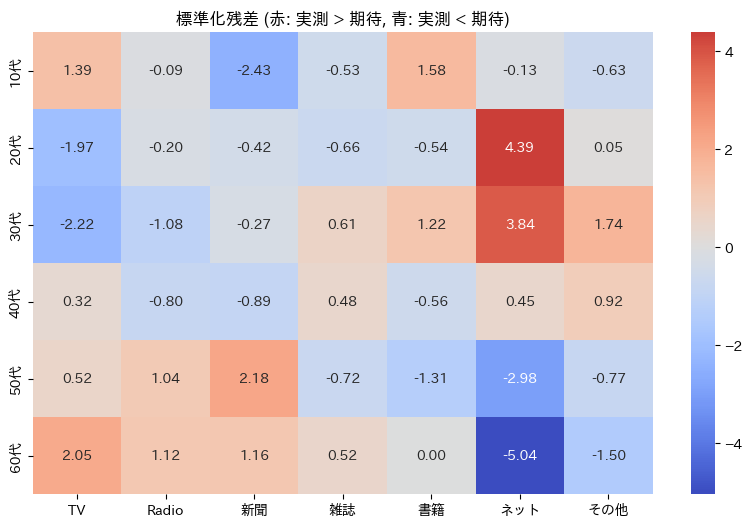

In [3]:
# 標準化残差
std_resid = (data - expected) / np.sqrt(expected)
df_resid = pd.DataFrame(std_resid, index=generations, columns=media)

plt.figure(figsize=(10, 6))
sns.heatmap(df_resid, annot=True, fmt=".2f", center=0, cmap="coolwarm")
plt.title("標準化残差 (赤: 実測 > 期待, 青: 実測 < 期待)")
plt.show()



**読み取り**:
*   **ネット**: 若年層（10-30代）で赤（多すぎる）、高齢層（50-60代）で青（少なすぎる）が顕著です。これがχ²統計量の主要な発生源です。
*   **新聞**: 若年層で青、高齢層で赤の傾向が見られます。



### 4. 対応分析 (Correspondence Analysis)



対応分析は、この標準化残差行列の特異値分解（SVD）に近い操作を行い、行と列を低次元空間（通常2次元）にプロットする手法です。
（正確には、$\frac{O_{ij}}{n} - \frac{R_i C_j}{n^2}$ を $\sqrt{R_i/n}$ と $\sqrt{C_j/n}$ で割ったものをSVDします）



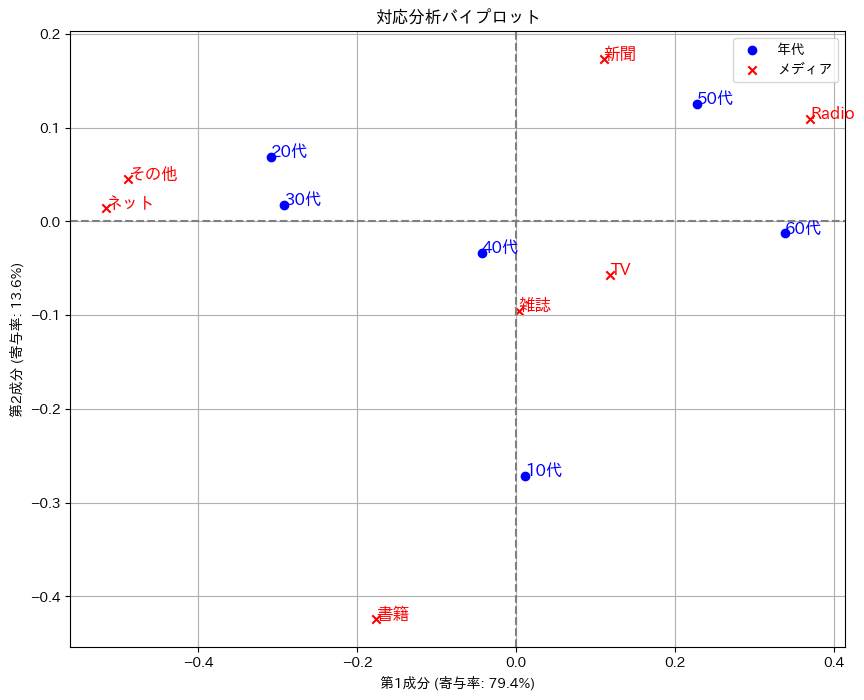

In [4]:
# 対応分析の実装 (簡易版: 標準化残差のSVDを利用)
# 厳密な対応分析の座標計算
P = data / n
r = P.sum(axis=1)
c = P.sum(axis=0)
D_r_inv_sqrt = np.diag(1 / np.sqrt(r))
D_c_inv_sqrt = np.diag(1 / np.sqrt(c))

# SVD対象行列 (Standardized Residuals Matrix for CA)
# Note: This corresponds to the matrix whose SVD gives the solution
S = D_r_inv_sqrt @ (P - np.outer(r, c)) @ D_c_inv_sqrt
U, s, Vt = np.linalg.svd(S, full_matrices=False)

# 座標計算 (Standard Coordinates)
# 行座標
row_coords = D_r_inv_sqrt @ U @ np.diag(s)
# 列座標
col_coords = D_c_inv_sqrt @ Vt.T @ np.diag(s)

# プロット
plt.figure(figsize=(10, 8))
# 行（年代）
plt.scatter(row_coords[:, 0], row_coords[:, 1], c='blue', marker='o', label='年代')
for i, txt in enumerate(generations):
    plt.annotate(txt, (row_coords[i, 0], row_coords[i, 1]), color='blue', fontsize=12)

# 列（メディア）
plt.scatter(col_coords[:, 0], col_coords[:, 1], c='red', marker='x', label='メディア')
for i, txt in enumerate(media):
    plt.annotate(txt, (col_coords[i, 0], col_coords[i, 1]), color='red', fontsize=12)

plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel(f"第1成分 (寄与率: {s[0]**2/np.sum(s**2):.1%})")
plt.ylabel(f"第2成分 (寄与率: {s[1]**2/np.sum(s**2):.1%})")
plt.title("対応分析バイプロット")
plt.legend()
plt.grid()
plt.show()



**〔17〕バイプロットの読み方**
*   近くにある項目同士は「相対的に結びつきが強い」ことを示します。
*   例えば「40代」と「新聞」が近くても、「40代の中で新聞が**最も多い**」とは限りません（絶対数の情報は失われています）。あくまで「平均的なパターンに比べて、40代は新聞への偏りが（他の年代より）似ている」という意味です。



### 5. 2×2表への縮約とZ検定（プーリング）との関係



問9の表を「40代以下 vs 50代以上」「ネット利用 vs その他」の2×2表に縮約してみます。
この場合、独立性のχ²検定は、2標本比率の差の検定（Z検定）と等価になります（$\chi^2 = Z^2$）。



In [5]:
# 2x2表の作成
# 行: 40代以下(0-3), 50代以上(4-5)
# 列: ネット(5), その他(0-4, 6)
row_grp1 = data[:4, :].sum(axis=0) # 10-40代
row_grp2 = data[4:, :].sum(axis=0) # 50-60代

net_grp1 = row_grp1[5]
other_grp1 = row_grp1.sum() - net_grp1

net_grp2 = row_grp2[5]
other_grp2 = row_grp2.sum() - net_grp2

table_2x2 = np.array([
    [net_grp1, other_grp1],
    [net_grp2, other_grp2]
])

print("2x2 Table (Net vs Other, <=40 vs >=50):")
print(table_2x2)

# χ²検定 (補正なし)
chi2_2x2, p_2x2, _, _ = stats.chi2_contingency(table_2x2, correction=False)
print(f"\nχ² (2x2): {chi2_2x2:.4f}")

# Z検定 (比率の差)
n1 = table_2x2[0].sum()
n2 = table_2x2[1].sum()
p1 = table_2x2[0, 0] / n1
p2 = table_2x2[1, 0] / n2
p_pool = (table_2x2[0, 0] + table_2x2[1, 0]) / (n1 + n2)

# 標準誤差 (Pooled)
se = np.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))
z = (p1 - p2) / se

print(f"Z値: {z:.4f}")
print(f"Z²: {z**2:.4f}")
print(f"一致確認: {abs(chi2_2x2 - z**2) < 1e-5}")


2x2 Table (Net vs Other, <=40 vs >=50):
[[216 727]
 [ 39 518]]

χ² (2x2): 62.7700
Z値: 7.9227
Z²: 62.7700
一致確認: True


## 問10：正則化回帰 (Lasso, Ridge, Elastic Net)



**〔18〕推定法と係数の縮小**
*   **(エ) OLS**: 正則化なし。係数は0にならず、分散が大きい。
*   **(イ) Ridge (L2)**: 係数全体を0の方へ縮小するが、完全に0にはなりにくい。
*   **(ウ) Lasso (L1)**: スパース性を持つ。多くの係数が完全に0になる。
*   **(ア) OLS + AIC**: 変数選択を行うためスパースになるが、選ばれた変数の係数は縮小されない（OLSのまま）。

**〔19〕Elastic Net ($\alpha=0.5$)**
*   Lasso ($\alpha=1$) と Ridge ($\alpha=0$) の中間的性質。
*   Lassoほど急激にスパースにはならないが、Ridgeよりは係数を0にしやすく、ある程度の変数選択効果と縮小効果を併せ持つ。



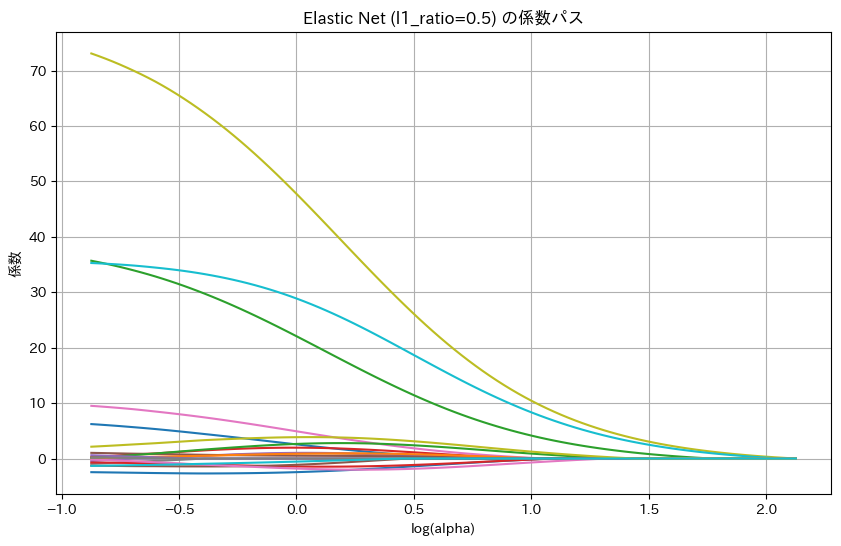

左に行くほど正則化が弱まり（alpha小）、係数が増大・出現します。


In [6]:
# Elastic Netのパス (概念デモ)
from sklearn.linear_model import enet_path
from sklearn.datasets import make_regression

# ダミーデータ生成
X, y = make_regression(n_samples=100, n_features=20, n_informative=5, noise=10, random_state=42)

# alpha=0.5 のパスを計算
alphas, coefs, _ = enet_path(X, y, l1_ratio=0.5)

plt.figure(figsize=(10, 6))
for coef_path in coefs:
    plt.plot(np.log10(alphas), coef_path)

plt.xlabel('log(alpha)')
plt.ylabel('係数')
plt.title('Elastic Net (l1_ratio=0.5) の係数パス')
plt.axis('tight')
plt.grid()
plt.show()
print("左に行くほど正則化が弱まり（alpha小）、係数が増大・出現します。")


## 問11：因子分析



**〔20〕共通性からの負荷量計算**
2因子モデルの場合、共通性 $h_j^2$ は因子負荷量 $a_{j1}, a_{j2}$ の二乗和です。
$$ h_j^2 = a_{j1}^2 + a_{j2}^2 $$
これを用いて、欠損している負荷量を逆算します。
*   高級感：$0.96^2 + (ア)^2 = 0.9412 \Rightarrow (ア)^2 \approx 0.0196 \Rightarrow |ア| \approx 0.14$
*   親しみ：$(-0.71)^2 + (イ)^2 = 0.8762 \Rightarrow (イ)^2 \approx 0.3721 \Rightarrow |イ| \approx 0.61$

**〔21〕バリマックス回転**
*   **単純構造**を目指す回転です。
*   各因子に対して、負荷量が高い変数の数を少なくし、解釈を容易にします（0に近いか、絶対値が大きいかの二極化を促す）。



## 問12：時系列解析 (ACFと分解)



**〔23〕ACF（自己相関関数）の読み取り**
*   **AR(1)**: 指数的に減衰します（$\phi^k$）。
*   **ランダムウォーク**: なかなか減衰せず、長期にわたって正の相関が残ります。
*   **季節性あり**: 周期（ラグ12など）ごとにスパイク（突出した相関）が現れます。
*   問12のデータは「年周期＋半年周期」の特徴があるため、ラグ6, 12, 18, 24... でピークを持つACF（選択肢⑤）が適切です。

**〔24〕成分分解と残差**
*   分解：$X_t = T_t + S_t + R_t$
*   図からトレンド $T_t$ の上昇や季節成分 $S_t$ の振幅は読み取れます。
*   しかし、「不規則成分 $R_t$ がホワイトノイズである」ことは、分解図だけでは断定できません。残差のACFをとったり、検定（Ljung-Box検定など）を行う必要があります。



/tmp/ipykernel_2864/2019123842.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_series = pd.Series(ts_data, index=pd.date_range(start='2012-04', periods=100, freq='M'))


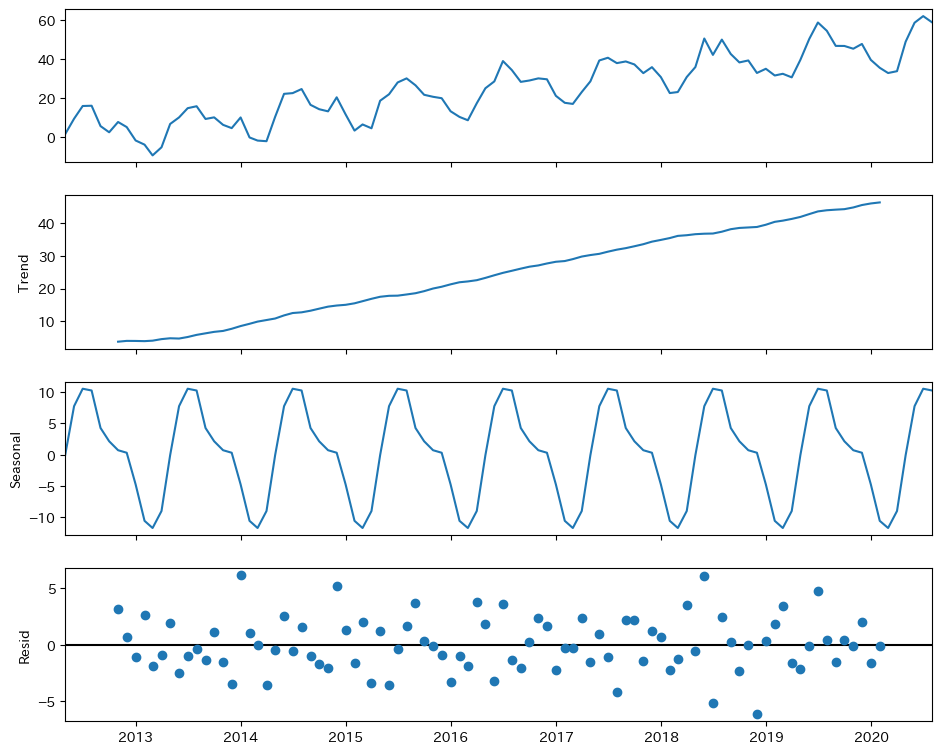

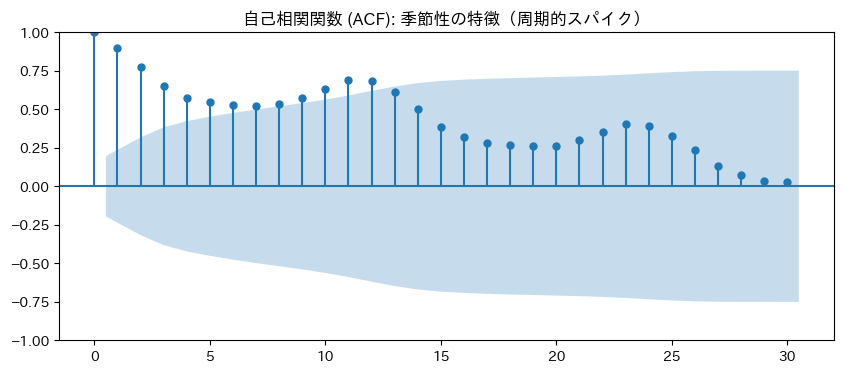

ACFを見ると、ラグ6, 12, 18... で相関が高くなっており、季節性が確認できます。


In [7]:
# 季節性データのシミュレーションと分解
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

# データ生成: トレンド + 季節性(周期12) + ノイズ
np.random.seed(42)
time = np.arange(100)
trend = 0.5 * time
seasonal = 10 * np.sin(2 * np.pi * time / 12) + 5 * np.sin(2 * np.pi * time / 6) # 1年+半年周期
noise = np.random.normal(0, 3, size=len(time))
ts_data = trend + seasonal + noise
ts_series = pd.Series(ts_data, index=pd.date_range(start='2012-04', periods=100, freq='M'))

# 分解 (加法モデル)
res = seasonal_decompose(ts_series, model='additive')

# プロット
fig = res.plot()
fig.set_size_inches(10, 8)
plt.show()

# ACFプロット
fig, ax = plt.subplots(figsize=(10, 4))
sm.graphics.tsa.plot_acf(ts_series, lags=30, ax=ax)
plt.title("自己相関関数 (ACF): 季節性の特徴（周期的スパイク）")
plt.show()

print("ACFを見ると、ラグ6, 12, 18... で相関が高くなっており、季節性が確認できます。")



### 補足：ARモデルとの統合理解
*   問9の$\chi^2$検定は「**空間的**なズレ（観測と期待の差）を標準化して足し合わせたもの」。
*   問12のACFは「**時間的**なズレ（自分と過去の共分散）を標準偏差で割って標準化したもの」。
*   どちらも「標準化して比較可能にする」という統計学の基本思想で繋がっています。

